In [1]:
import pandas as pd
tama_df = pd.read_csv('engineered_tama_data.csv', index_col='year').sort_values(by=['city_code', 'year'])
tama_df = tama_df[tama_df['hebrew_city_name'] == 'ירושלים']
tama_df

,hebrew_city_name,city_code,total_open_requests,total_requests,total_approved_requests
year,,,,,
2005,ירושלים,3000,0,0.0,0.0
2006,ירושלים,3000,0,1.0,0.0
2007,ירושלים,3000,1,0.0,0.0
2008,ירושלים,3000,1,1.0,0.0
2009,ירושלים,3000,2,2.0,0.0
2010,ירושלים,3000,4,4.0,0.0
2011,ירושלים,3000,8,6.0,1.0
2012,ירושלים,3000,13,6.0,7.0
2013,ירושלים,3000,12,13.0,3.0


<Axes: xlabel='year'>

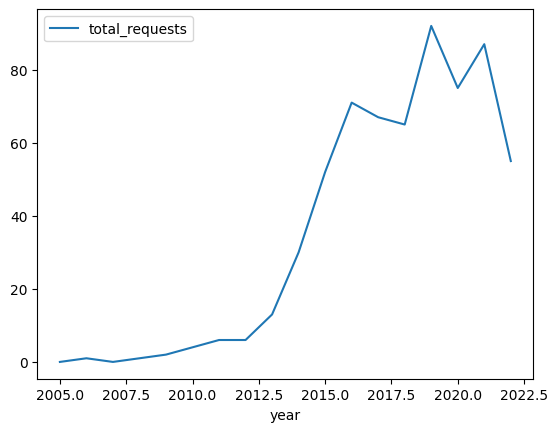

In [2]:
tama_df[['total_requests']].plot()

In [3]:
# Split the data into training and testing sets
train_data = tama_df.loc[:2018, 'total_requests']
test_data = tama_df.loc[2019:, 'total_requests']

In [5]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Define the parameters for the TimeseriesGenerator
sequence_length = 3  # Length of the input sequences
batch_size = 1 
# Create the TimeseriesGenerator for training data
train_generator = TimeseriesGenerator(train_data, train_data.values.reshape(-1, 1), length=sequence_length, batch_size=batch_size)
# Create the TimeseriesGenerator for testing data
test_generator = TimeseriesGenerator(test_data, test_data.values.reshape(-1, 1), length=sequence_length, batch_size=batch_size)

2023-12-19 18:59:13.585728: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/200


/var/folders/9d/pylsgxd55jj55h_1svvmnmjm0000gn/T/ipykernel_87759/2023864376.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(generator=train_generator,


11/11 [==============================] - 2s 34ms/step - loss: 1607.4766 - val_loss: 2631.1655
Epoch 2/200
11/11 [==============================] - 0s 6ms/step - loss: 1494.6887 - val_loss: 1898.0786
Epoch 3/200
11/11 [==============================] - 0s 6ms/step - loss: 1279.1056 - val_loss: 660.8409
Epoch 4/200
11/11 [==============================] - 0s 7ms/step - loss: 838.0695 - val_loss: 334.6930
Epoch 5/200
11/11 [==============================] - 0s 6ms/step - loss: 347.6418 - val_loss: 42716.5703
Epoch 6/200
11/11 [==============================] - 0s 7ms/step - loss: 3678.9404 - val_loss: 74581.0781
Epoch 7/200
11/11 [==============================] - 0s 7ms/step - loss: 1438.3668 - val_loss: 5127.4219
Epoch 8/200
11/11 [==============================] - 0s 7ms/step - loss: 376.5560 - val_loss: 764.5593
Epoch 9/200
11/11 [==============================] - 0s 6ms/step - loss: 450.3183 - val_loss: 703.3924
Epoch 10/200
11/11 [==============================] - 0s 6ms/step - loss

<Axes: >

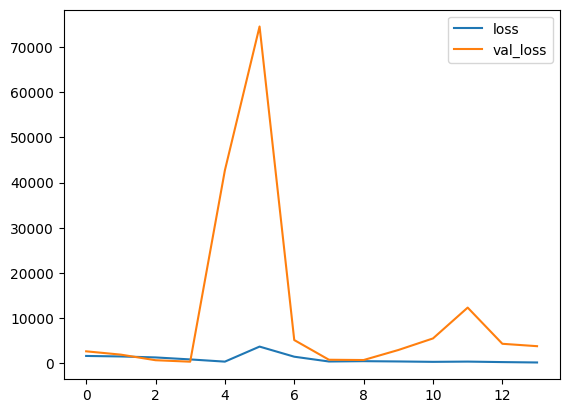

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1), activation = 'relu'))
model.add(LSTM(units=50, return_sequences=False, activation = 'relu'))

model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


model_early_stopping = EarlyStopping(monitor='val_loss',patience=10)
model_history = model.fit_generator(generator=train_generator,
                                        validation_data=test_generator,
                                        epochs=200,
                                        callbacks=[model_early_stopping])

losses = pd.DataFrame(model.history.history)
losses.plot()

In [25]:
tama_df['predict_total_requests'] = None
tama_df.loc[2005 + sequence_length: 2018, 'predict_total_requests'] = model.predict(train_generator)
tama_df.loc[2019, 'predict_total_requests'] = model.predict(tama_df.loc[2016: 2018, 'total_requests'].values.reshape(1, sequence_length))[0][0]
tama_df.loc[2020, 'predict_total_requests'] = model.predict(tama_df.loc[2017: 2019, 'total_requests'].values.reshape(1, sequence_length))[0][0]
tama_df.loc[2021, 'predict_total_requests'] = model.predict(tama_df.loc[2018: 2020, 'total_requests'].values.reshape(1, sequence_length))[0][0]
tama_df.loc[2022, 'predict_total_requests'] = model.predict(test_generator)[0][0]

1/1 [==============================] - 0s 28ms/step


In [44]:
tama_df['predict_total_requests'] = tama_df['predict_total_requests'].fillna(tama_df['total_requests'])
tama_df[['total_requests', 'predict_total_requests']]

,total_requests,predict_total_requests
year,,
2005,0.0,0.000000
2006,1.0,1.000000
2007,0.0,0.000000
2008,1.0,0.961700
2009,2.0,1.400222
2010,4.0,1.242694
2011,6.0,3.258968
2012,6.0,8.011047
2013,13.0,16.921051


<Axes: xlabel='year'>

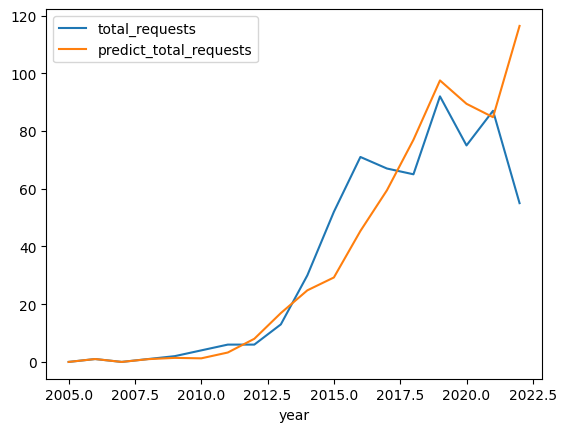

In [45]:
tama_df[['total_requests', 'predict_total_requests']].plot()

In [39]:
from sklearn.metrics import mean_squared_error
import numpy as np
np.sqrt(mean_squared_error(tama_df.loc[2008:2018, 'total_requests'], tama_df.loc[2008:2018, 'predict_total_requests']))

11.42675822841006

In [42]:
np.sqrt(mean_squared_error(tama_df.loc[2019:, 'total_requests'], tama_df.loc[2019:, 'predict_total_requests']))

31.675363600714196